In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import warnings
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "6"
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "6"
warnings.simplefilter('ignore')

In [4]:
computation_kwargs = {'cuda_visible_devices': 0}

In [5]:
sys.path = sys.path[1:]
sys.path.append(os.path.abspath(os.pardir))
#sys.path.append(os.path.join(os.path.abspath(os.pardir), 'odometry'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tfoptflow/tfoptflow'))
sys.path.append(os.path.join(os.path.abspath(os.pardir), 'submodules/tf_models/research/struct2depth'))

## Data

In [6]:
optical_flow_checkpoint = '/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000'
#optical_flow_checkpoint = os.path.abspath(../weights/pwcnet.ckpt-595000')  # official weights
print('optical flow', optical_flow_checkpoint)

depth_checkpoint = os.path.abspath('../weights/model-199160')
print('depth', depth_checkpoint)

optical flow /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000
depth /Vol0/user/a.vorontsova/odometry/weights/model-199160


In [7]:
dataframe = pd.read_csv('/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/00/df.csv', index_col=0)
#dataframe = pd.read_csv('meetingroom_04_rgbd_ir_imu_pose_KITTI_finetuned/df.csv', index_col=0)
dataframe.head()

,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,path_to_rgb,path_to_next_rgb,euler_x,euler_y,euler_z,x,...,pc_y,pc_z,pc_error_x,pc_error_y,pc_error_z,optical_flow_pwc_skip1_mean_flow,optical_flow_pwc_skip1_mean_flow_normalized,optical_flow_gt_skip1_normalized,optical_flow_pc_skip1_normalized,optical_flow_refined_skip1_normalized
0,0,0,0,0,image_2/000000.png,image_2/000001.png,0.001156,-0.002066,-0.000530,-0.046903,...,-0.007980,0.651822,0.102688,0.102415,1.117522,optical_flow_pwc_skip1_mean_flow/000000_000001...,optical_flow_pwc_skip1_mean_flow_normalized/00...,optical_flow_gt_skip1_normalized/000000_000001...,optical_flow_pc_skip1_normalized/000000_000001...,optical_flow_refined_skip1_normalized/000000_0...
1,1,1,1,1,image_2/000001.png,image_2/000002.png,0.001155,-0.002063,-0.000526,-0.045053,...,-0.001540,0.657672,0.080215,0.059430,0.448673,optical_flow_pwc_skip1_mean_flow/000001_000002...,optical_flow_pwc_skip1_mean_flow_normalized/00...,optical_flow_gt_skip1_normalized/000001_000002...,optical_flow_pc_skip1_normalized/000001_000002...,optical_flow_refined_skip1_normalized/000001_0...
2,2,2,2,2,image_2/000002.png,image_2/000003.png,0.001158,-0.002065,-0.000525,-0.043324,...,-0.002982,0.689013,0.066281,0.063574,0.882052,optical_flow_pwc_skip1_mean_flow/000002_000003...,optical_flow_pwc_skip1_mean_flow_normalized/00...,optical_flow_gt_skip1_normalized/000002_000003...,optical_flow_pc_skip1_normalized/000002_000003...,optical_flow_refined_skip1_normalized/000002_0...
3,3,3,3,3,image_2/000003.png,image_2/000004.png,0.001157,-0.002063,-0.000522,-0.041485,...,-0.007164,0.697135,0.102181,0.096504,1.106223,optical_flow_pwc_skip1_mean_flow/000003_000004...,optical_flow_pwc_skip1_mean_flow_normalized/00...,optical_flow_gt_skip1_normalized/000003_000004...,optical_flow_pc_skip1_normalized/000003_000004...,optical_flow_refined_skip1_normalized/000003_0...
4,4,4,4,4,image_2/000004.png,image_2/000005.png,0.001160,-0.002065,-0.000520,-0.039747,...,-0.009273,0.717733,0.085257,0.082203,1.697354,optical_flow_pwc_skip1_mean_flow/000004_000005...,optical_flow_pwc_skip1_mean_flow_normalized/00...,optical_flow_gt_skip1_normalized/000004_000005...,optical_flow_pc_skip1_normalized/000004_000005...,optical_flow_refined_skip1_normalized/000004_0...


In [8]:
dataframe = dataframe[['x', 'y', 'z', 'euler_x', 'euler_y', 'euler_z', 'path_to_rgb']]
dataframe.path_to_rgb = dataframe.path_to_rgb.apply(
    lambda x: os.path.join('/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/00/', x))
dataframe.head()

,x,y,z,euler_x,euler_y,euler_z,path_to_rgb
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...


## Estimators

In [9]:
dataset_root = 'test_estimators'

#height = 120
#width = 160

height = 94
width = 300

In [10]:
from odometry.preprocessing.estimators import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



### Single input

In [11]:
index, row = next(dataframe.iterrows())
row

x                                                     -0.0469029
y                                                     -0.0283993
z                                                       0.858694
euler_x                                               0.00115596
euler_y                                              -0.00206633
euler_z                                             -0.000529652
path_to_rgb    /dbstore/datasets/KITTI_odometry_2012/dataset/...
Name: 0, dtype: object

In [12]:
struct2depth_estimator = Struct2DepthEstimator(input_col='path_to_rgb',
                                               output_col='path_to_depth',
                                               directory='depth',
                                               checkpoint=depth_checkpoint, 
                                               height=height,
                                               width=width)
struct2depth_estimator

Instructions for updating:
Colocations handled automatically by placer.


W0611 19:20:42.448976 47042464067200 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use keras.layers.batch_normalization instead.


W0611 19:20:42.464520 47042464067200 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tf_models/research/struct2depth/nets.py:503: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.batch_normalization instead.
W0611 19:20:44.383913 47042464067200 util.py:204] Shape mismatch, will not restore egomotion_prediction/pose_exp_net/pose/cnv6/weights.
W0611 19:20:44.384790 47042464067200 util.py:206] The following variables in the checkpoint were not loaded:


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0611 19:20:45.100392 47042464067200 deprecation.py:323] From /Vol0/user/a.vorontsova/miniconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


I0611 19:20:45.102547 47042464067200 saver.py:1270] Restoring parameters from /Vol0/user/a.vorontsova/odometry/weights/model-199160


Estimator(dir=depth, input_col=path_to_rgb, output_col=path_to_depth, checkpoint=/Vol0/user/a.vorontsova/odometry/weights/model-199160)

In [13]:
row = struct2depth_estimator.run(row, dataset_root)
row

x                                                       -0.0469029
y                                                       -0.0283993
z                                                         0.858694
euler_x                                                 0.00115596
euler_y                                                -0.00206633
euler_z                                               -0.000529652
path_to_rgb      /dbstore/datasets/KITTI_odometry_2012/dataset/...
path_to_depth                     test_estimators/depth/000000.npy
Name: 0, dtype: object

### Double input

In [14]:
dataframe = dataframe[:-1].join(dataframe[1:].copy().reset_index(), rsuffix='_next')
dataframe.drop('index', axis=1, inplace=True)
dataframe.head()

,x,y,z,euler_x,euler_y,euler_z,path_to_rgb,x_next,y_next,z_next,euler_x_next,euler_y_next,euler_z_next,path_to_rgb_next
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,-0.037913,-0.023508,0.858240,0.001159,-0.002062,-0.000517,/dbstore/datasets/KITTI_odometry_2012/dataset/...


In [15]:
index, row = next(dataframe.iterrows())
row

x                                                          -0.0469029
y                                                          -0.0283993
z                                                            0.858694
euler_x                                                    0.00115596
euler_y                                                   -0.00206633
euler_z                                                  -0.000529652
path_to_rgb         /dbstore/datasets/KITTI_odometry_2012/dataset/...
x_next                                                     -0.0450533
y_next                                                     -0.0273947
z_next                                                       0.857708
euler_x_next                                               0.00115542
euler_y_next                                              -0.00206321
euler_z_next                                             -0.000526483
path_to_rgb_next    /dbstore/datasets/KITTI_odometry_2012/dataset/...
Name: 0, dtype: obje

In [16]:
input_col = ['euler_x', 'euler_y', 'euler_z', 'x', 'y', 'z',
             'euler_x_next', 'euler_y_next', 'euler_z_next', 'x_next', 'y_next', 'z_next']
output_col = ['rx', 'ry', 'rz', 'tx', 'ty', 'tz']
global2relative_estimator = Global2RelativeEstimator(input_col=input_col, output_col=output_col)
global2relative_estimator

Estimator(input_col=['euler_x', 'euler_y', 'euler_z', 'x', 'y', 'z', 'euler_x_next', 'euler_y_next', 'euler_z_next', 'x_next', 'y_next', 'z_next'], output_col=['rx', 'ry', 'rz', 'tx', 'ty', 'tz'])

In [17]:
row = global2relative_estimator.run(row, dataset_root)
row

x                                                          -0.0469029
y                                                          -0.0283993
z                                                            0.858694
euler_x                                                    0.00115596
euler_y                                                   -0.00206633
euler_z                                                  -0.000529652
path_to_rgb         /dbstore/datasets/KITTI_odometry_2012/dataset/...
x_next                                                     -0.0450533
y_next                                                     -0.0273947
z_next                                                       0.857708
euler_x_next                                               0.00115542
euler_y_next                                              -0.00206321
euler_z_next                                             -0.000526483
path_to_rgb_next    /dbstore/datasets/KITTI_odometry_2012/dataset/...
rx                  

In [18]:
pwcnet_estimator = PWCNetEstimator(input_col=['path_to_rgb', 'path_to_rgb_next'],
                                   output_col='path_to_optical_flow',
                                   directory='optical_flow',
                                   checkpoint=optical_flow_checkpoint,
                                   height=height,
                                   width=width)
pwcnet_estimator

Building model...
Instructions for updating:
Use keras.layers.conv2d instead.


W0611 19:21:14.055674 47042464067200 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1173: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d instead.


Instructions for updating:
Use keras.layers.conv2d_transpose instead.


W0611 19:21:15.294107 47042464067200 deprecation.py:323] From /Vol0/user/a.vorontsova/odometry/submodules/tfoptflow/tfoptflow/model_pwcnet.py:1300: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


... model built.
Loading model checkpoint /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000 for eval or testing...

INFO:tensorflow:Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


I0611 19:21:19.425765 47042464067200 saver.py:1270] Restoring parameters from /Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000


... model loaded


Estimator(dir=optical_flow, input_col=['path_to_rgb', 'path_to_rgb_next'], output_col=path_to_optical_flow, checkpoint=/Vol0/user/f.konokhov/tfoptflow/tfoptflow/tmp/pwcnet.ckpt-84000)

In [19]:
row = pwcnet_estimator.run(row, dataset_root)
row

x                                                              -0.0469029
y                                                              -0.0283993
z                                                                0.858694
euler_x                                                        0.00115596
euler_y                                                       -0.00206633
euler_z                                                      -0.000529652
path_to_rgb             /dbstore/datasets/KITTI_odometry_2012/dataset/...
x_next                                                         -0.0450533
y_next                                                         -0.0273947
z_next                                                           0.857708
euler_x_next                                                   0.00115542
euler_y_next                                                  -0.00206321
euler_z_next                                                 -0.000526483
path_to_rgb_next        /dbstore/datas

### Visual check

In [20]:
!ls test_estimators

depth  optical_flow


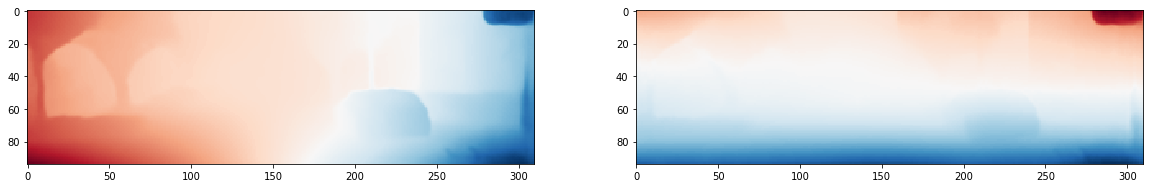

In [21]:
import matplotlib.pyplot as plt

flow = np.load('test_estimators/optical_flow/000001.npy')

fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
ax[0].imshow(flow[..., 0], cmap='RdBu')
ax[1].imshow(flow[..., 1], cmap='RdBu')
plt.show()

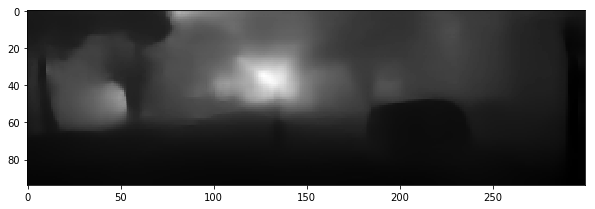

In [22]:
depth = np.load('test_estimators/depth/000000.npy')

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(depth[..., 0], cmap='gray')
plt.show()

### Full pipeline

In [23]:
dataframe = pd.read_csv('/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/00/df.csv', index_col=0)
dataframe = dataframe[['x', 'y', 'z', 'euler_x', 'euler_y', 'euler_z', 'path_to_rgb']]
dataframe.path_to_rgb = dataframe.path_to_rgb.apply(
    lambda x: os.path.join('/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/00/', x))
print(dataframe.shape)
dataframe.head()

(4540, 7)


,x,y,z,euler_x,euler_y,euler_z,path_to_rgb
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...


In [24]:
single_estimators = [struct2depth_estimator]
double_estimators = [global2relative_estimator, pwcnet_estimator]

In [25]:
rows = []
for index, row in dataframe.iterrows():
    for estimator in single_estimators:
        row = estimator.run(row, dataset_root)
    rows.append(row)
    
dataframe = pd.DataFrame(rows)
print(dataframe.shape)
dataframe.head()

(4540, 8)


,x,y,z,euler_x,euler_y,euler_z,path_to_rgb,path_to_depth
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000000.npy
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000001.npy
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000002.npy
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000003.npy
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000004.npy


In [26]:
dataframe = dataframe[:-1].join(dataframe[1:].copy().reset_index(), rsuffix='_next')
dataframe.drop('index', axis=1, inplace=True)
print(dataframe.shape)
dataframe.head()

(4539, 16)


,x,y,z,euler_x,euler_y,euler_z,path_to_rgb,path_to_depth,x_next,y_next,z_next,euler_x_next,euler_y_next,euler_z_next,path_to_rgb_next,path_to_depth_next
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000000.npy,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000001.npy
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000001.npy,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000002.npy
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000002.npy,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000003.npy
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000003.npy,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000004.npy
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000004.npy,-0.037913,-0.023508,0.858240,0.001159,-0.002062,-0.000517,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000005.npy


In [27]:
rows = []
for index, row in dataframe.iterrows():
    for estimator in double_estimators:
        row = estimator.run(row, dataset_root)
    rows.append(row)

dataframe = pd.DataFrame(rows)
print(dataframe.shape)
dataframe.head()

(4539, 23)


,x,y,z,euler_x,euler_y,euler_z,path_to_rgb,path_to_depth,x_next,y_next,...,euler_z_next,path_to_rgb_next,path_to_depth_next,rx,ry,rz,tx,ty,tz,path_to_optical_flow
0,-0.046903,-0.028399,0.858694,0.001156,-0.002066,-0.000530,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000000.npy,-0.045053,-0.027395,...,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000001.npy,-5.320257e-07,0.000003,0.000003,0.001847,0.001004,-0.000991,test_estimators/optical_flow/000001.npy
1,-0.045053,-0.027395,0.857708,0.001155,-0.002063,-0.000526,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000001.npy,-0.043324,-0.026460,...,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000002.npy,2.466066e-06,-0.000002,0.000002,0.001732,0.000937,0.001226,test_estimators/optical_flow/000002.npy
2,-0.043324,-0.026460,0.858939,0.001158,-0.002065,-0.000525,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000002.npy,-0.041485,-0.025457,...,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000003.npy,-3.886896e-07,0.000003,0.000003,0.001836,0.001003,-0.000893,test_estimators/optical_flow/000003.npy
3,-0.041485,-0.025457,0.858051,0.001157,-0.002063,-0.000522,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000003.npy,-0.039747,-0.024513,...,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000004.npy,2.324596e-06,-0.000002,0.000002,0.001740,0.000946,0.001112,test_estimators/optical_flow/000004.npy
4,-0.039747,-0.024513,0.859167,0.001160,-0.002065,-0.000520,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000004.npy,-0.037913,-0.023508,...,-0.000517,/dbstore/datasets/KITTI_odometry_2012/dataset/...,test_estimators/depth/000005.npy,-4.306027e-07,0.000003,0.000003,0.001832,0.001005,-0.000933,test_estimators/optical_flow/000005.npy
